## Synthetic Spectrum

Here we test VAMP on a synthetic spectrum of a massive central galaxy in the s43 SIMBA simulation, generated using [Pygad](https://bitbucket.org/broett/pygad/src/master/) for the CII 1036 Angstrom line.

In [1]:
import numpy as np
import h5py

%matplotlib inline
import matplotlib.pyplot as plt

import vpfits
from vpfits import *

from scipy.ndimage.filters import gaussian_filter
from scipy.signal import argrelextrema

import pymc as mc
from pymc.Matplot import plot
from scipy import stats
from copy import copy
import gc

import corner

SyntaxError: invalid syntax (vpfits.py, line 95)

First let's define some constants.

In [2]:
# Rest wavelength of the CII 1036 line:
l0 = 1036. # angstroms

# Speed of light:
c = 2.9e18 # angstroms / s

# Rest frequency of the CII 1035 line:
nu0 = c / l0

# Cross section
# sigma0 = (sqrt(pi)e**2) / (m_e*c**2)  
sigma0 = 0.0263 # cm**2/s
sigma0 = 2.63e-6 # m**2/s

Load in the dataset and extract the data.

In [3]:
data = h5py.File('data/spectrum_pygad_CII1036.h5', 'r')
data.keys()

[u'density_col',
 u'flux',
 u'noise',
 u'tau',
 u'temp',
 u'velocity',
 u'wavelength']

In [4]:
wavelength = data['wavelength'][:]
flux = data['flux'][:]
noise = data['noise'][:]
taus = data['tau'][:]

nu = c / wavelength 

In [5]:
# Initialise the vpfits instance

vpfit = vpfits.VPfit()

In [6]:
# Identify regions in the spectrum to fit

min_region_width = 2
regions, region_pixels = vpfits.compute_detection_regions(wavelength, taus, flux, noise,
                                          min_region_width=min_region_width)

Computing detection regions...
Found 4 detection regions.


Plot the spectrum as frequency against flux, and see the regions we've identified:

In [7]:
def plot_bracket(x, axis, dir):
    height = .2
    arm_length = 0.2
    axis.plot((x, x), (1-height/2, 1+height/2), color='magenta')

    if dir=='left':
        xarm = x+arm_length
    if dir=='right':
        xarm = x-arm_length

    axis.plot((x, xarm), (1-height/2, 1-height/2), color='magenta')
    axis.plot((x, xarm), (1+height/2, 1+height/2), color='magenta')

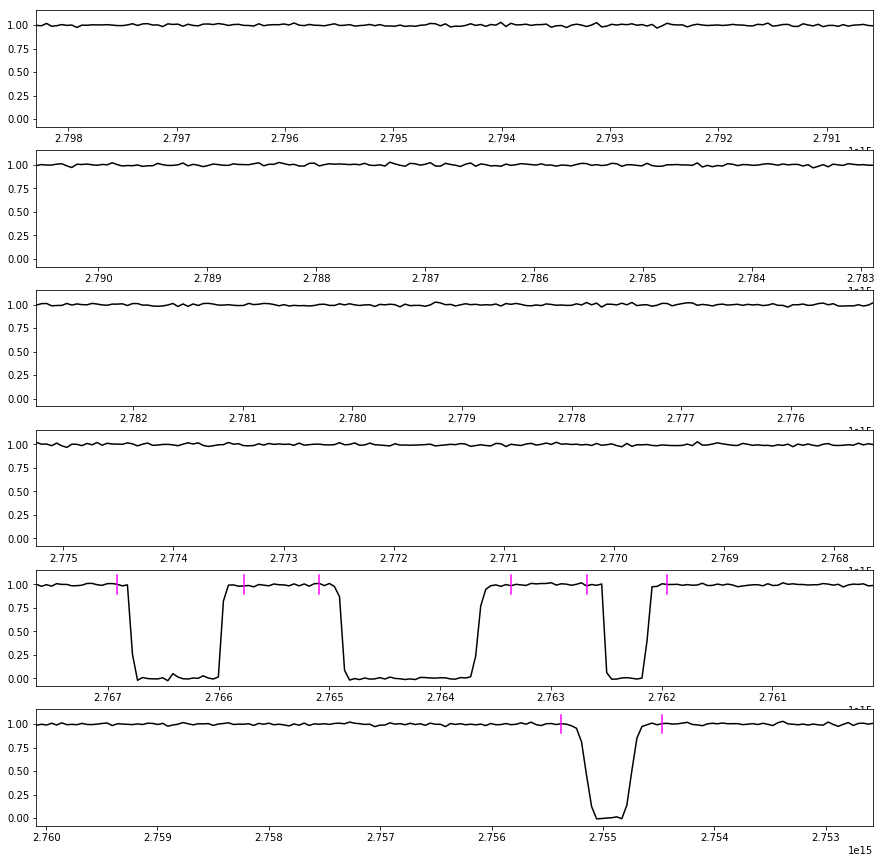

In [8]:
N = 6
fig, ax = plt.subplots(N, figsize=(15,15))

length = len(flux) / N

for n in range(N):
    
    lower_lim = n*length
    upper_lim = n*length+length
    
    ax[n].plot(nu, flux, c='black')
    
    ax[n].set_xlim(nu[lower_lim], nu[upper_lim])

    for (start, end) in region_pixels:
        ax[n].plot(wavelength[start:end+1], flux[start:end+1], color='blue')
        plot_bracket(nu[start], ax[n], 'left')
        plot_bracket(nu[end], ax[n], 'right')

plt.show()

Setting initial number of lines to: 1
Old BIC value of -6.24 is greater than the current -7.24.
Increasing the number of lines to: 3
Old BIC value of -7.24 is greater than the current -64.00.
Increasing the number of lines to: 4
Old BIC value of -64.00 is greater than the current -98.68.
Increasing the number of lines to: 5
BIC increased with increasing the line number, stopping.
Final n=4.


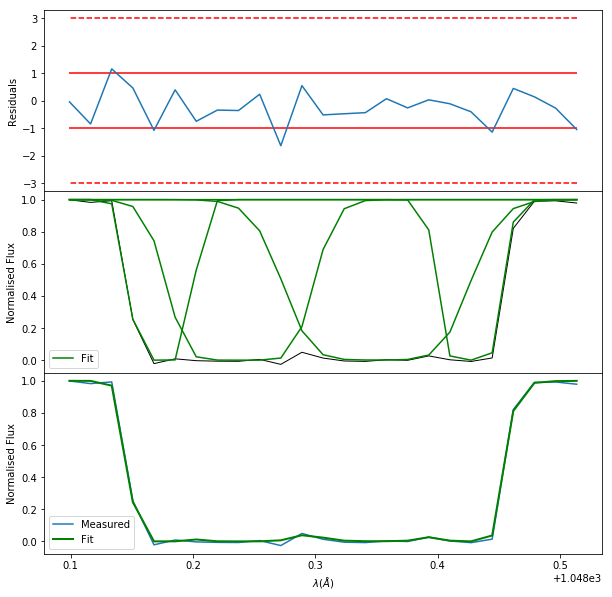

Setting initial number of lines to: 1
Old BIC value of -25.29 is greater than the current -38.74.
Increasing the number of lines to: 3
Old BIC value of -38.74 is greater than the current -151.13.
Increasing the number of lines to: 4
BIC increased with increasing the line number, stopping.
Final n=3.


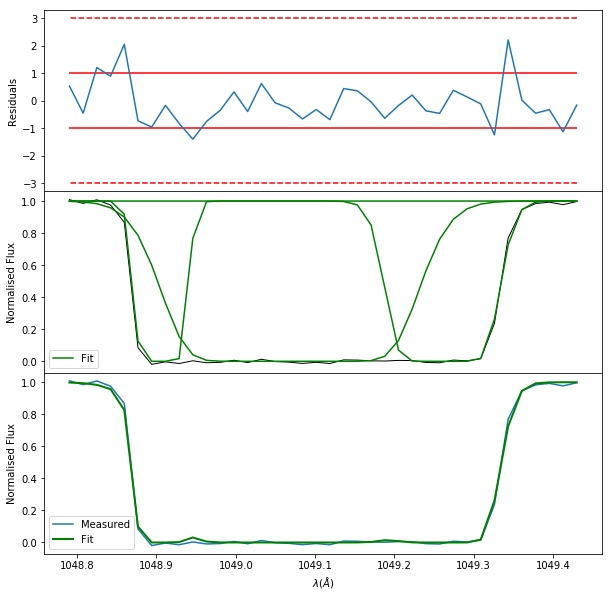

Setting initial number of lines to: 1
Old BIC value of -11.18 is greater than the current -40.02.
Increasing the number of lines to: 3
BIC increased with increasing the line number, stopping.
Final n=2.


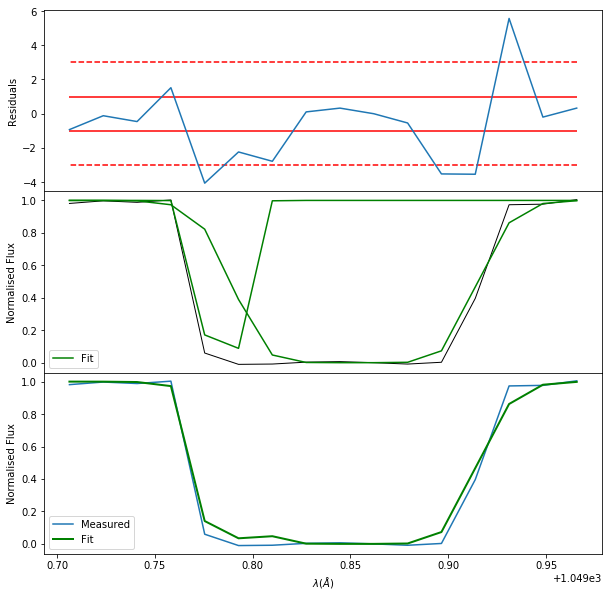

Setting initial number of lines to: 1
BIC increased with increasing the line number, stopping.
Final n=1.


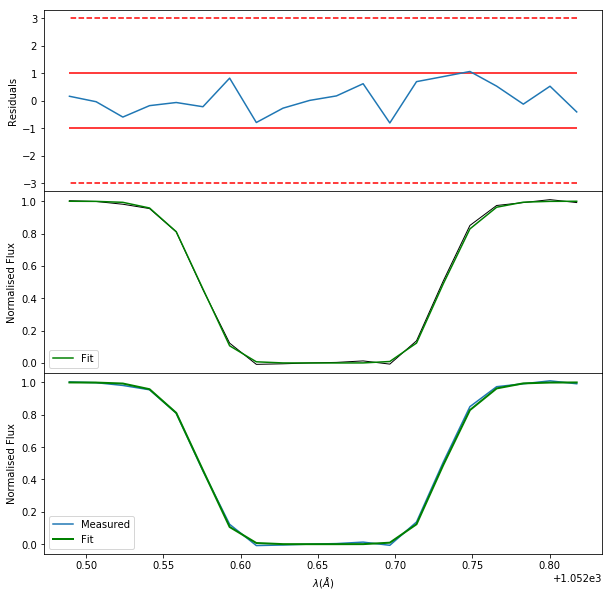

In [21]:
for start, end in region_pixels:
    wavelengths = np.flip(wavelength[start:end], 0)
    fluxes_orig = np.flip(flux[start:end], 0)
    fluxes = np.flip(flux[start:end], 0)
    nu_use = np.flip(nu[start:end], 0)
    noises = np.flip(noise[start:end], 0)

    n = estimate_n(fluxes)
    freedom = len(nu_use) + 3
    stuff = region_fit(nu_use, fluxes, n, noises, freedom)
    n = len(stuff.estimated_profiles)
    stuff.plot(wavelengths, fluxes_orig, n=n, start_pix=start, end_pix=end)
    

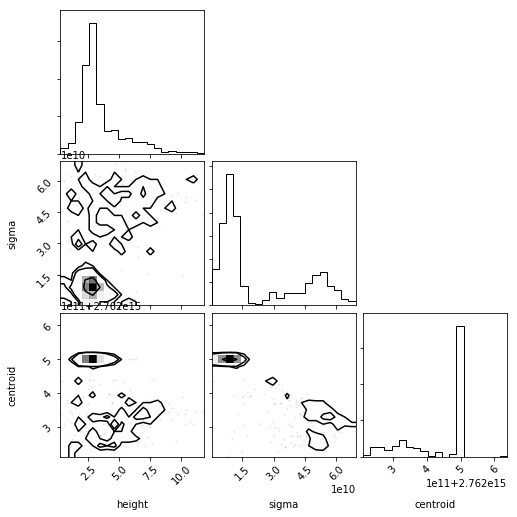

In [12]:
height_samples = stuff.mcmc.trace(stuff.estimated_variables[3]['height'])[:]
sigma_samples = stuff.mcmc.trace(stuff.estimated_variables[3]['sigma'])[:]
centroid_samples = stuff.mcmc.trace(stuff.estimated_variables[3]['centroid'])[:]

samples = np.transpose(np.array([height_samples, sigma_samples, centroid_samples]))

fig = corner.corner(samples, labels=['height', 'sigma', 'centroid'])

In [13]:
n = len(stuff.estimated_variables)
heights = np.array([stuff.estimated_variables[i]['height'].value for i in range(n)])
sigmas = np.array([stuff.estimated_variables[i]['sigma'].value for i in range(n)])
centers = np.array([stuff.estimated_variables[i]['centroid'].value for i in range(n)])

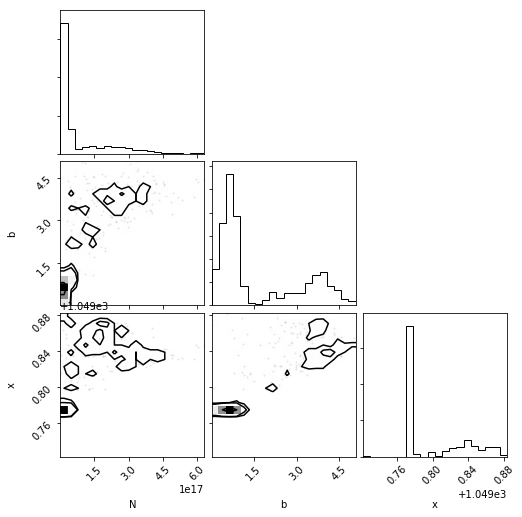

In [14]:
b = l0*1.e-13*sigma_samples / np.sqrt(2)
N = height_samples*sigma_samples*np.sqrt(2*np.pi) / sigma0

t = vpfit.GaussFunction(nu_use, heights[0], centers[0], sigmas[0])

l_centroids = c/centroid_samples

phys_samples = np.transpose(np.array([N, b, l_centroids]))
fig = corner.corner(phys_samples, labels=['N', 'b', 'x'])